# 7月5日课程作业

In [12]:
import numpy as np
import pyvista as pv

from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

首先加载并可视化一个双环面，如下所示：

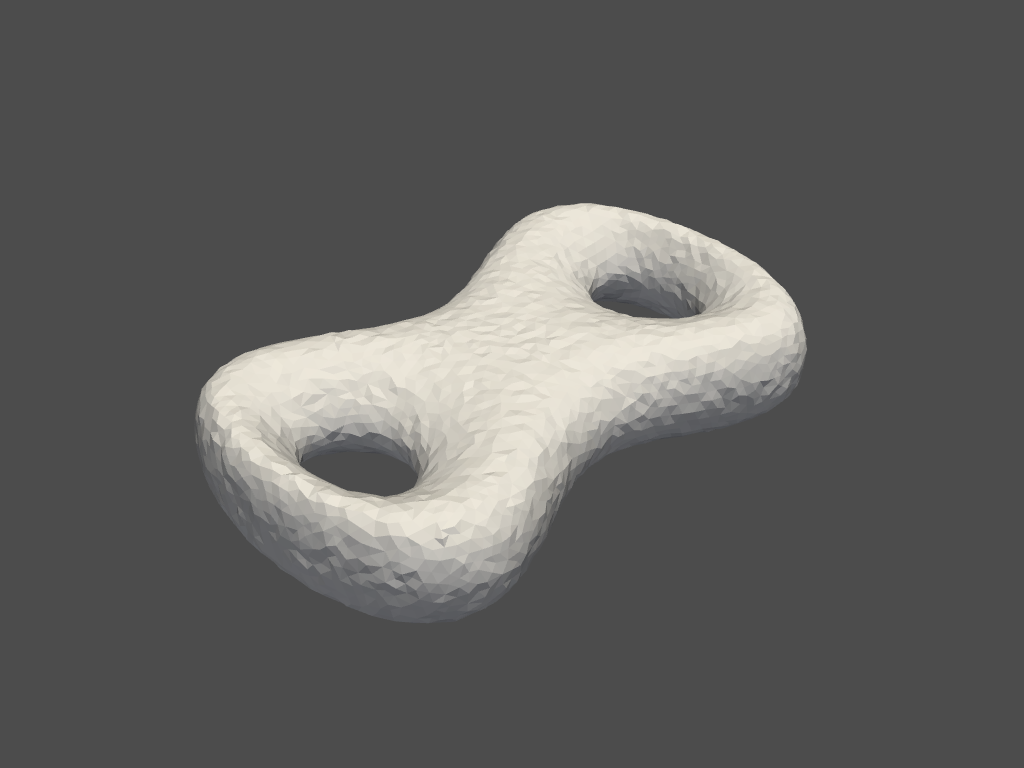

In [2]:
mesh = pv.read('../../data/doubletorus.vtu')
mesh.plot(screenshot='../../data/doubletorus.png')

mesh 有一定的结构，我们可以看到其中的所有顶点，如下：

In [16]:
mesh.points

pyvista_ndarray([[ 0.168123  , -0.0755884 , -0.202557  ],
                 [-0.0540063 , -0.446305  , -0.00309186],
                 [ 0.0884401 , -0.366978  , -0.15543   ],
                 ...,
                 [ 0.76968   ,  0.666641  ,  0.0145876 ],
                 [ 0.561993  , -0.595955  , -0.14418   ],
                 [ 0.637573  , -0.291708  ,  0.131263  ]])

In [52]:
mesh.points[:, 0].min(), mesh.points[:, 0].max()

(pyvista_ndarray(-1.08352), pyvista_ndarray(1.08496))

In [53]:
mesh.points[:, 1].min(), mesh.points[:, 1].max()

(pyvista_ndarray(-0.67445), pyvista_ndarray(0.673291))

In [54]:
mesh.points[:, 2].min(), mesh.points[:, 2].max()

(pyvista_ndarray(-0.204469), pyvista_ndarray(0.204986))

In [ ]:
我们可以给点染色，效果如下

In [84]:
mesh.point_arrays['pvalues'] = np.linspace(0.0, 1.0, mesh.n_points)
mesh.plot(scalars='pvalues', show_edges=True, screenshot='points_coloring.png')

ValueError: Number of scalars (2) must match either the number of points (5159) or the number of cells (10322). 

基于上面的 API，让我们试验一下一个双环面上一个燃烧的过程，火从一点开始向外蔓延，遇到已经燃烧过的就停下蔓延，我们把停止蔓延处的点都记录下来。

初始时刻，只有第 0 点处在着火，其他点全部是未着火的状态。

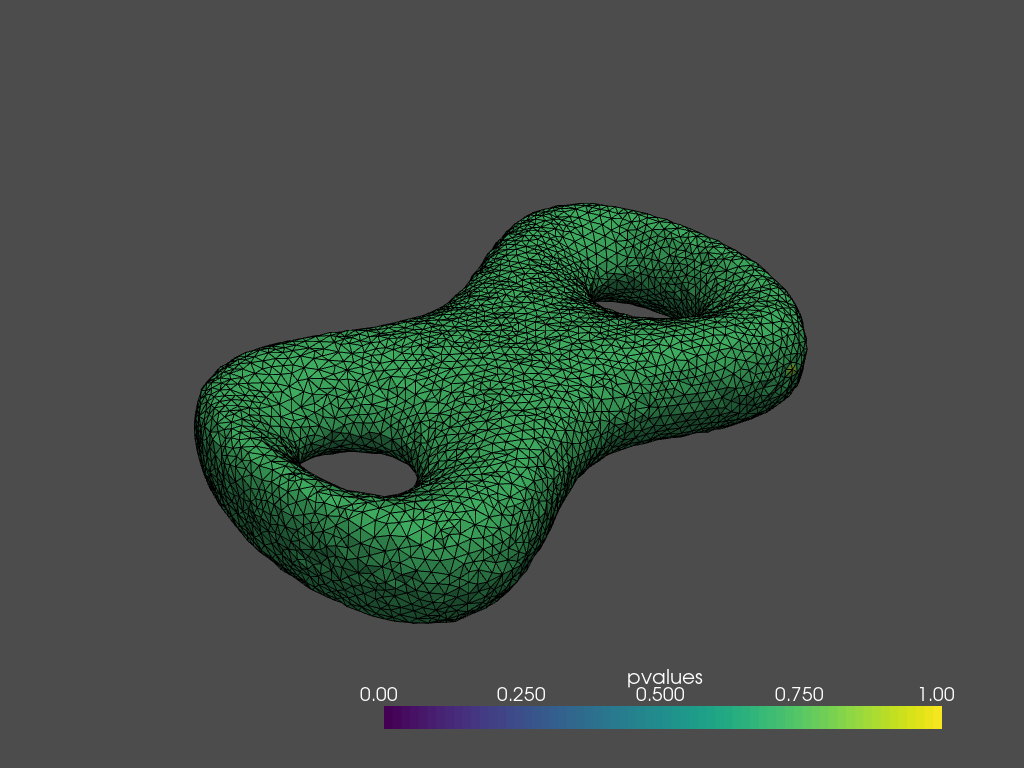

In [77]:
mesh.point_arrays['pvalues'] = np.ones([mesh.n_points]) * 0.7 # 绿色的森林
mesh.point_arrays['pvalues'][0] = 0.0                         # 强制把色阶拉回去的 workaround
mesh.point_arrays['pvalues'][5000] = 1.0                      # 着火处
mesh.plot(scalars='pvalues', show_edges=True, screenshot='points_coloring.png')

In [82]:
def step():
    for i in range(mesh.n_points):
        p = mesh.points[i]
        pval = mesh.point_arrays['pvalues'][i]
        if pval > 0.75:                              # 如果 p 点正在燃烧
            for j in range(mesh.n_points):
                q = mesh.points[j]
                qval = mesh.point_arrays['pvalues'][j]
                d = np.sqrt(np.sum((p - q) * (p - q)))
                meet_cond = False
                if d < 0.05:
                    if qval == 0.7:                  # 如果 q 点尚未燃烧过
                        mesh.point_arrays['pvalues'][j] = 1.0
                        meet_cond = False
                    elif qval > 0.75 or qval == 0.0: # 如果 q 点也在燃烧
                        meet_cond = meet_cond and (pval > qval)

            mesh.point_arrays['pvalues'][i] = mesh.point_arrays['pvalues'][i] * 0.9
            if 0.7 < mesh.point_arrays['pvalues'][i] < 0.75:
                mesh.point_arrays['pvalues'][i] = 0.5

            if meet_cond:
                mesh.point_arrays['pvalues'][i] = 0.0

    mesh.point_arrays['pvalues'][0] = 0.0

In [83]:
step()